In [94]:
# Dependencies
import numpy as np
import pandas as pd
import datetime
import calendar

import matplotlib.pyplot as plt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.sql import select
from sqlalchemy import extract  

In [135]:
import requests
import gmaps

# Import API key
from config import g_key
# Configure gmaps API key
gmaps.configure(api_key=g_key)

In [ ]:
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [ ]:
Base.classes.keys()

In [ ]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [96]:
# Create our session (link) from Python to the DB
session = Session(engine)

## D1: Determine the Summary Statistics for June

In [97]:
# 1. Import the sqlalchemy extract function.
#from sqlalchemy import extract

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [98]:
# column names
columns = inspector.get_columns('measurement')
for i in columns:
    print(i['name'], i["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [99]:
#get column names
columns = inspector.get_columns('station')
for i in columns:
    print(i['name'],i['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [136]:
# 2. Write a query that filters the Measurement table to retrieve the temperatures for the month of June.
results_June = []
results_June = session.query(Measurement.tobs, Measurement.prcp,Measurement.date).filter(extract('month', Measurement.date)==6).all()

In [101]:
#  3. Convert the June temperatures to a list.
#don't think this is required?

In [137]:
# 4. Create a DataFrame from the list of temperatures for the month of June. 
df_June = pd.DataFrame(results_June, columns = ['temperature','precipitation','date'])

df_June.head()

,temperature,precipitation,date
0,78.0,0.00,2010-06-01
1,76.0,0.01,2010-06-02
2,78.0,0.00,2010-06-03
3,76.0,0.00,2010-06-04
4,77.0,0.00,2010-06-05


In [138]:
# 5. Calculate and print out the summary statistics for the June temperature DataFrame.
df_June.describe()


,temperature,precipitation
count,1700.000000,1574.000000
mean,74.944118,0.136360
std,3.257417,0.335731
min,64.000000,0.000000
25%,73.000000,0.000000
50%,75.000000,0.020000
75%,77.000000,0.120000
max,85.000000,4.430000


In [139]:
#additional analysis for June
df_June['year'] = pd.DatetimeIndex(df_June['date']).year
df_June.head()

df_June_byyear = df_June.groupby(['year']).mean()
df_June_byyear

,temperature,precipitation
year,,
2010,74.925620,0.042241
2011,73.938326,0.240142
2012,74.000000,0.097062
2013,74.599078,0.144195
2014,75.027907,0.124372
2015,74.990148,0.125160
2016,75.175258,0.212312
2017,77.219895,0.120000


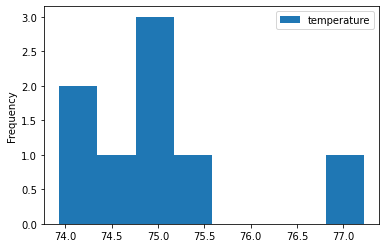

In [105]:
df_June_byyear.plot.hist(bins = 8)

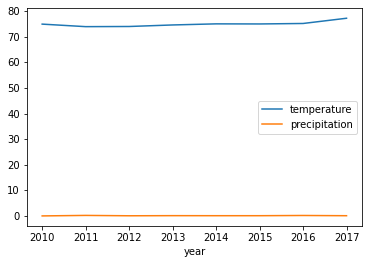

In [145]:
df_June_byyear.plot.line()

## D2: Determine the Summary Statistics for December

In [147]:
# 6. Write a query that filters the Measurement table to retrieve the temperatures for the month of December.
results_Dec = []
results_Dec = session.query(Measurement.tobs,Measurement.prcp,Measurement.date).filter(extract('month', Measurement.date)==12).all()

In [148]:
# 7. Convert the December temperatures to a list.
#don't think this is required...?

In [149]:
# 8. Create a DataFrame from the list of temperatures for the month of December. 
df_Dec = pd.DataFrame(results_Dec, columns = ['temperature','precipitation','date'])

df_Dec.head()

,temperature,precipitation,date
0,76.0,0.04,2010-12-01
1,74.0,0.00,2010-12-03
2,74.0,0.00,2010-12-04
3,64.0,0.00,2010-12-06
4,64.0,0.00,2010-12-07


In [150]:
# 9. Calculate and print out the summary statistics for the Decemeber temperature DataFrame.
df_Dec.describe()

,temperature,precipitation
count,1517.000000,1405.000000
mean,71.041529,0.216819
std,3.745920,0.541399
min,56.000000,0.000000
25%,69.000000,0.000000
50%,71.000000,0.030000
75%,74.000000,0.150000
max,83.000000,6.420000


In [111]:
#additional analysis

df_Dec['year'] = pd.DatetimeIndex(df_Dec['date']).year
df_Dec_byyear = df_Dec.groupby(['year']).mean()
df_Dec_byyear


,temperature
year,
2010,70.208511
2011,70.820628
2012,71.188073
2013,71.094017
2014,69.896861
2015,73.423913
2016,71.130000


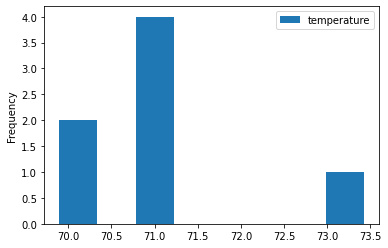

In [112]:
df_Dec_byyear.plot.hist(bins = 8)

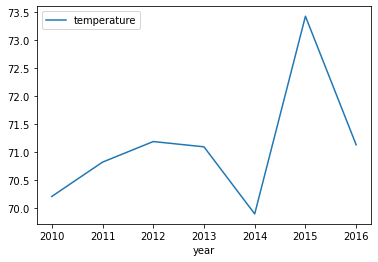

In [113]:
df_Dec_byyear.plot.line()

In [114]:
#connect the tables together for more analyis of weather vs station characteristics
conn = engine.connect()
s = select([Measurement, Station]).where(Measurement.station==Station.station) 

result2 = conn.execute(s)

df_joined = pd.DataFrame(result2, columns = ['index','station1','date','precipitation','temperature','index2','station','name','lat','long','elevation'])        

df_joined = df_joined.drop(['index2','index','station1'],axis =1)
df_joined.head(2)


,date,precipitation,temperature,station,name,lat,long,elevation
0,2010-01-01,0.08,65.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2010-01-02,0.00,63.0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [115]:
#drop the high elevation ones because not that relevant to our analysis
df_joined.drop(df_joined[df_joined.elevation > 50].index, inplace=True)

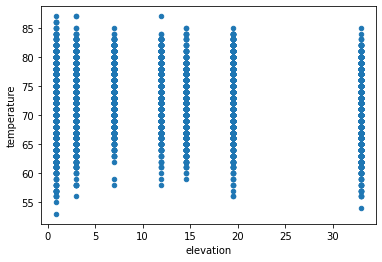

In [116]:
df_joined.plot.scatter(y = 'temperature', x= 'elevation')

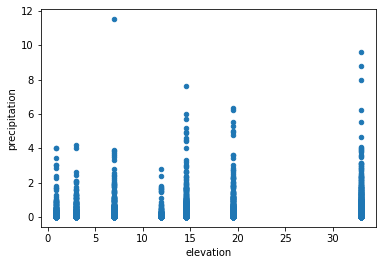

In [117]:
df_joined.plot.scatter(y = 'precipitation', x = 'elevation')

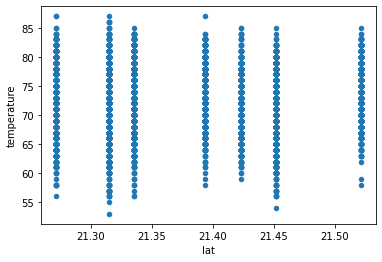

In [118]:
df_joined.plot.scatter(y = 'temperature', x= 'lat')

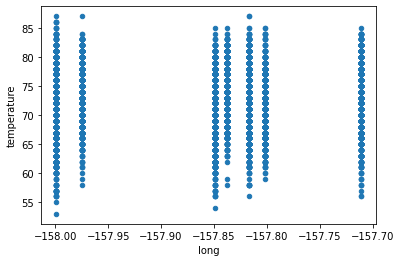

In [119]:
df_joined.plot.scatter(y = 'temperature', x= 'long')

In [120]:
#find the weather station with the best weather, that is also at the coast (ie zero elevation)
df_grouped = df_joined.groupby(by = 'name').mean().sort_values(by =['temperature'])

In [121]:
df_grouped

,precipitation,temperature,lat,long,elevation
name,,,,,
"HONOLULU OBSERVATORY 702.2, HI US",0.047971,71.615968,21.31520,-157.99920,0.9
"WAIHEE 837.5, HI US",0.212352,71.663781,21.45167,-157.84889,32.9
"KANEOHE 838.1, HI US",0.141921,72.689184,21.42340,-157.80150,14.6
"WAIMANALO EXPERIMENTAL FARM, HI US",0.114961,74.543649,21.33556,-157.71139,19.5
"WAIKIKI 717.2, HI US",0.049020,74.553231,21.27160,-157.81680,3.0
"PEARL CITY, HI US",0.063602,74.684402,21.39340,-157.97510,11.9
"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.121058,74.873297,21.52130,-157.83740,7.0


In [122]:
df_grouped['index']= [0,1,2,3,4,5,6]
df_clean = df_grouped.set_index('index')
df_clean['short_name']=['Honolulu', 'Waihee', 'Kaneohe', 'Waimanalo', 'Wakiki', 'Pearl City', 'Kualoa Ranch']
df_clean

,precipitation,temperature,lat,long,elevation,short_name
index,,,,,,
0,0.047971,71.615968,21.31520,-157.99920,0.9,Honolulu
1,0.212352,71.663781,21.45167,-157.84889,32.9,Waihee
2,0.141921,72.689184,21.42340,-157.80150,14.6,Kaneohe
3,0.114961,74.543649,21.33556,-157.71139,19.5,Waimanalo
4,0.049020,74.553231,21.27160,-157.81680,3.0,Wakiki
5,0.063602,74.684402,21.39340,-157.97510,11.9,Pearl City
6,0.121058,74.873297,21.52130,-157.83740,7.0,Kualoa Ranch


In [123]:
info_box_template = """
<dl>
<dt>Weather Station Name</dt><dd>{short_name}</dd>
<dt>Average Precipitation</dt><dd>{precipitation}</dd>
<dt>Average Temperature</dt><dd>{temperature}</dd>
</dl>
"""
# 10a. Get the data from each row and add it to the formatting template and store the data in a list.

weather_station_info = [info_box_template.format(**row) for index, row in df_clean.iterrows()]

# 10b. Get the latitude and longitude from each row and store in a new DataFrame.
locations = df_clean[["lat", "long"]]

In [134]:
# 11a. Add a marker layer for each city to the map. 
# 11b. Display the figure

fig = gmaps.figure(center=(21.0, -157.0), zoom_level=8, layout={'width': '1200px','height': '600px'})
marker_layer = gmaps.marker_layer(locations, info_box_content=weather_station_info)
fig.add_layer(marker_layer)
# Call the figure to plot the data.
fig

Figure(layout=FigureLayout(height='600px', width='1200px'))